# Toward AI Sustainability: Low-Level Optimization for High Impact

**ESPCI 2025: Practical work guide**

This document presents instructions and questions regarding the practical work sessions of this course. All the materials (slides, notebooks, base codes) can be recovered from the corresponding [GitHub repository](https://github.com/Deyht/green_ai).

The notebook can be run locally (at ESPCI after the command "conda activate simul") or on google colab directly: 
[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/Deyht/green_ai_espci/blob/main/green_ai_espci.ipynb)


This notebook is **not intended as a standalone** document, the slides should be used as a reference to understand several of the explanations provided in the analysis of the results.

# Practical work 1: Optimization and HPC

This first part tackles the subject of high-performance computing for the matrix multiplication operation, which is the **main operation in all modern AI models**.

We can consider that the total energy consumed by a given computation can be approximated by $E = \Delta P\times T$, with $E$ the energy in Joules, $\Delta P$ the increase in power draw compared to the system baseline in Watts, and $T$ the total time of the computation in seconds. We will first consider that $\Delta P$ is constant so the consumed energy is simply proportional to the time of execution. Note that this is a strong simplification and that it completely neglects several aspects of the environmental impact of ICT and ignores possible rebound effects (see the slides for more details).

Overall, the objective of this part will be to find the most efficient way of implementing the matrix multiplication operation and, therefore, reduce the amount of energy required.

We will implement a classical matrix multiply operation between an $M\times K$ matrix $A$ and a $K \times N$ matrix $B$ to obtain an $M\times N$ matrix $C$. The content of an element of $C$ is given by:
\begin{equation}
C(i,j) = \sum_k A(i,k)\times B(k,j)
\end{equation}
The indices $i$, $j$, and $k$ go through $M$, $N$, and $K$, respectively.


In this part, we will compare different implementations of this operation and evaluate the impact of the programming language (interpreted with Python and compiled with C), low-level optimization, and parallelization. The example presented in this notebook were inspired and derived from [Algorithmica](https://en.algorithmica.org/hpc/algorithms/matmul/). We invite the reader to have a look at the chapter on matrix multiplication.

*We note that we will mostly follow the triple loop algorithm and ignore possible alternatives like the Strassen algorithm as such alternative formulations are mostly interesting for large matrices and are more difficult to optimize for the memory hierarchy of numerical systems.*

---

**System informations**

Before going further, you should gather information about the system you are running this notebook on (be it your laptop, a workstation, or a cloud service). Assuming you run on a Linux-based system, the following command will provide details about your system CPU. To interpret the results of this notebook, you should identify the number of cores/threads, the amount of L1/L2/L3 cache, and the supported instructions sets (AVX2). Some information might be missing, like the distribution of cores in P and E cores for Intel CPUs, but it can be found by searching the CPU model name online. To get a more detailed view of the memory hierachy of your system you can run the *lstopo* command (require the *hwloc* package).

In [1]:
import os

print(os.popen("lscpu").read())

""" #Uncomment block on GoogleColab for installing and running lstopo
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

os.system("apt install hwloc")
os.system("lstopo --of png > system_topography.png")
image = mpimg.imread("system_topography.png")
plt.figure(figsize=(6,4), dpi=200)
plt.imshow(image)
plt.show()
"""

Architecture:                         x86_64
CPU op-mode(s):                       32-bit, 64-bit
Byte Order:                           Little Endian
Address sizes:                        48 bits physical, 48 bits virtual
CPU(s):                               24
On-line CPU(s) list:                  0-23
Thread(s) per core:                   2
Core(s) per socket:                   12
Socket(s):                            1
NUMA node(s):                         1
Vendor ID:                            AuthenticAMD
CPU family:                           25
Model:                                33
Model name:                           AMD Ryzen 9 5900X 12-Core Processor
Stepping:                             0
Frequency boost:                      enabled
CPU MHz:                              2697.508
CPU max MHz:                          3700,0000
CPU min MHz:                          2200,0000
BogoMIPS:                             7399.91
Virtualization:                       AMD-V
L1d cac

' #Uncomment block on GoogleColab for installing and running lstopo\nimport matplotlib.pyplot as plt\nimport matplotlib.image as mpimg\n\nos.system("apt install hwloc")\nos.system("lstopo --of png > system_topography.png")\nimage = mpimg.imread("system_topography.png")\nplt.figure(figsize=(6,4), dpi=200)\nplt.imshow(image)\nplt.show()\n'

## Python: Naive, compiled and built-in matrix multiplication

### Matmul Naive: triple nested loop

The following cell contains the most naive implementations of the matrix multiplication operation, **matmul_naive**, composed of three nested loops.

We rely on the **time** library to measure its execution time. All computations are made using 32-bit (single precision) floating point variables arranged in numpy arrays. We also force numpy to use only one thread (for the moment) for a fair comparison with our non-parallelized custom functions.

We start by establishing a performance baseline with $M=N=K=512$ for our matrices sizes.

***Note:** Compute time predictions can vary due to other loads on the system. Ideally, you should run your compute time estimations a few times to average the variability.*

In [2]:
#Must cover all cases as numpy does not expose which version of BLAS it uses
os.environ["OMP_NUM_THREADS"] = "1"
os.environ["OPENBLAS_NUM_THREADS"] = "1"
os.environ["MKL_NUM_THREADS"] = "1"
os.environ["NUMEXPR_NUM_THREADS"] = "1"
os.system("export OMP_NUM_THREADS=1")
os.system("export OPENBLAS_NUM_THREADS=1")
os.system("export MKL_NUM_THREADS=1")
os.system("export NUMEXPR_NUM_THREADS=1")
import numpy as np
import time as time

np.random.seed(0)

def matmul_naive(A, B, C, M, N, K):
    for i in range(0,M):
        for j in range(0,N):
            for k in range(0,K):
                C[i,j] += A[i,k] * B[k,j]

size = 512

M = size; N = size; K = size

A = (np.random.random((M,K)).astype("float32")-0.5)*0.1
B = (np.random.random((K,N)).astype("float32")-0.5)-0.1
C = np.zeros((M,N), dtype="float32")

t_start = time.time()

matmul_naive(A, B, C, M, N, K)

matmul_naive_ref_time = time.time() - t_start

print ("matmul_naive compute time: %f s"%(matmul_naive_ref_time))

matmul_naive compute time: 37.448760 s


---
### Matmul numpy inner sum

In order to improve the performances, we can replace the inner loop of the previous function with an elment-wise product of two vectors and use **numpy** to sum the resulting elements. The use of vectorized operations should reduce the computation time.

In [3]:
def matmul_numpy_sum(A, B, C, M, N, K):
    for i in range(0,M):
        for j in range(0,N):
            C[i,j] = np.sum(A[i,:]*B[:,j])


t_start = time.time()

matmul_numpy_sum(A, B, C, M, N, K)

matmul_numpy_sum_time = time.time() - t_start

print ("matmul_numpy_sum time: %f s"%(matmul_numpy_sum_time))
print ("Speedup over naive: %f"%(matmul_naive_ref_time/matmul_numpy_sum_time))

matmul_numpy_sum time: 0.973610 s
Speedup over naive: 38.463805


---
### Numba compilation

Python is an **interpreted** programming language, so conversion to machine language (compilation) is done on the fly on a per-line basis. However, some libraries like **numba** can be used to compile compatible Python functions in a C-like fashion.

The following cell provides numba-compiled versions of the previous functions and evaluates the resulting speedup.

***Note:** Functions with numba headers are compiled the first time they are called, taking time, and then kept in cache for future reuse. As a precaution, we always execute the function a first time before measuring its execution time.*


In [4]:
from numba import jit #JIT stant for "Just In Time" compilation

@jit(nopython=True, cache=True, fastmath=False)
def compiled_matmul_naive(A, B, C, M, N, K):
    for i in range(0,M):
        for j in range(0,N):
            for k in range(0,K):
                C[i,j] += A[i,k] * B[k,j]

@jit(nopython=True, cache=True, fastmath=False)
def compiled_matmul_numpy_sum(A, B, C, M, N, K):
    for i in range(0,M):
        for j in range(0,N):
            C[i,j] = np.sum(A[i,:]*B[:,j])

compiled_matmul_naive(A, B, C, M, N, K)
compiled_matmul_numpy_sum(A, B, C, M, N, K)

t_start = time.time()
compiled_matmul_naive(A, B, C, M, N, K)
compiled_matmul_naive_time = time.time() - t_start

t_start = time.time()
compiled_matmul_numpy_sum(A, B, C, M, N, K)
compiled_matmul_numpy_sum_time = time.time() - t_start

print ("compiled_naive time: %f s, and speedup compared to non-compiled: %f"%
    (compiled_matmul_naive_time, matmul_naive_ref_time/compiled_matmul_naive_time))
print ("compiled_sum time: %f s, and speedup compared to non-compiled: %f"%
    (compiled_matmul_numpy_sum_time, matmul_numpy_sum_time/compiled_matmul_numpy_sum_time))

compiled_naive time: 0.216146 s, and speedup compared to non-compiled: 173.256596
compiled_sum time: 0.289207 s, and speedup compared to non-compiled: 3.366480


We see that the two compiled functions reach similar computation times, with a huge speedup for the naive version, while the speedup of the numpy_sum version speedup is relatively small.
Most of the speed improvement we first observed with the non-compiled numpy_sum function comes from the fact that vectorized operations and most numpy functions rely on pre-compiled functions. Therefore, using numba to compile the matmul_numpy_sum only improve the two outer loops, while the most critical inner loop was already replaced by a compiled operation.

---
### Performance curve

To better represent the computing efficiency of different implementations, we can estimate the number of floating-point operations per second (FLOPS). This can be done by dividing the total number of "useful" operations by the total time of computation.

For matrix multiplication where $M=N=K$ the number of operations is simply $N^3$. This scaling law shows that the compute time will increase exponentially with the size of the matrices.

The following cells measure the compute time as a function of the problem size for the compiled naive implementation and draw the corresponding performance curve.

You can try to adapt the size-step in order to better catch the moment where the total size of all matrices in bytes ($ 3*N^2*4$ for simple precision floating points (4 bytes) and considering $M=N=K$) is larger than the amount of L3 cache in your system. You can also try to change the function for the compiled numpy_sum version.

In [5]:

def perf_curve_fct(c_fct, start=128, end=1920, size_step=128):

    nb_steps = (end-start+size_step)//size_step
    gflops_per_size = np.zeros((nb_steps,2))

    M = start; N = start; K = start

    A = (np.random.random((M,K)).astype("float32")-0.5)*0.1
    B = (np.random.random((K,N)).astype("float32")-0.5)-0.1
    C = np.zeros((M,N), dtype="float32")

    #first non-measured call in case it need to be recompiled
    c_fct(A, B, C, M, N, K)

    for i in range(0,nb_steps):

        l_size = start + i*size_step
        M = l_size; N = l_size; K = l_size

        A = (np.random.random((M,K)).astype("float32")-0.5)*0.1
        B = (np.random.random((K,N)).astype("float32")-0.5)-0.1
        C = np.zeros((M,N), dtype="float32")

        t_start = time.time()
        c_fct(A, B, C, M, N, K)

        elapsed_time = time.time() - t_start

        gflops_per_size[i,0] = l_size
        gflops_per_size[i,1] = l_size**3/1e9/elapsed_time

    return gflops_per_size


In [6]:
#Actual computation of the curve, might take some time
compiled_naive_gflops_curve = perf_curve_fct(compiled_matmul_naive, start=64, end=1920, size_step=64)

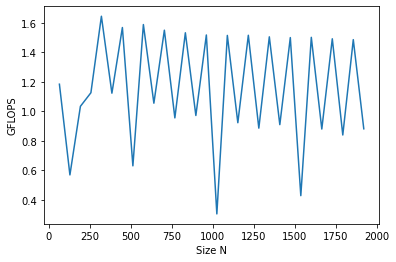

In [7]:
import matplotlib.pyplot as plt

plt.plot(compiled_naive_gflops_curve[:,0], compiled_naive_gflops_curve[:,1])
plt.gca().set_xlabel("Size N")
plt.gca().set_ylabel("GFLOPS")
plt.show()

In theory, this curve should highlight that the performances (GLFOPS) first increase with the size of the matrices until they cannot fit in the L3 CPU cache anymore. After this point, the performances go back down with the problem size and exhibit a relatively undeterministic/noisy behavior. This implementation is currently strongly bandwidth-limited with some added latency specific to python for large problems.

---
### Built-in python and numpy matmul

We now compare our compiled naive implementation with build-in and optimized implementations available in Python.

In [8]:
size = 1024 #Larger than before since all functions are quite fast

M = size; N = size; K = size

A = (np.random.random((M,K)).astype("float32")-0.5)*0.1
B = (np.random.random((K,N)).astype("float32")-0.5)-0.1
C = np.zeros((M,N), dtype="float32")


compiled_matmul_naive(A, B, C, M, N, K)
t_start = time.time()
compiled_matmul_naive(A, B, C, M, N, K)
compiled_matmul_naive_time = time.time() - t_start

t_start = time.time()
C = A@B
at_operator_time = time.time() - t_start

t_start = time.time()
C = np.matmul(A,B)
numpy_builtin_matmul_time = time.time() - t_start


print ("Compiled_naive time: %f s"%(compiled_matmul_naive_time))
print ("@ operator time: %f s"%(at_operator_time))
print ("Numpy builtin matmul time: %f s"%(numpy_builtin_matmul_time))

Compiled_naive time: 4.721327 s
@ operator time: 0.017995 s
Numpy builtin matmul time: 0.016594 s


In [9]:
def numpy_builtin_matmul_wrapper(A, B, C, M, N, K):
    C = np.matmul(A,B)
    
#Actual computation of the curve, might take some time
numpy_builtin_matmul_gflops_curve = perf_curve_fct(numpy_builtin_matmul_wrapper, start=128, end=3072, size_step=128)

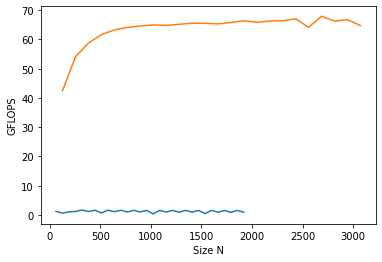

In [10]:
plt.plot(compiled_naive_gflops_curve[:,0], compiled_naive_gflops_curve[:,1], label="Compiled Naiv")
plt.plot(numpy_builtin_matmul_gflops_curve[:,0], numpy_builtin_matmul_gflops_curve[:,1], label="Numpy Built-in")

plt.gca().set_xlabel("Size N")
plt.gca().set_ylabel("GFLOPS")
plt.show()

We can see that the performance of the built-in numpy matmul function is not only much higher than our custom implementation (even with compilation) but also maintained for large problem sizes, which indicates that it is likely compute-limited and not bandwidth-limited anymore.

The secret is that it uses the highly optimized openBLAS C library in the background (see numpy [linalg](https://numpy.org/doc/2.1/reference/routines.linalg.html#module-numpy.linalg)). The very purpose of the following part will be to explain how we can achieve such a level of performance in C.

## C: Optimized low-level matrix multiplication

In this part, we will analyze multiple implementations of the matrix multiplication operation in C with increasing levels of optimization and complexity.

While the C programming language supports multi-dimensional array indexing (but no vectorized operations), most implementations (and low-level C libraries) opt for a flattened matrix formalism. This choice more explicitly exposes the actual arrangement of the data in the system memory and allows us to identify possible cache-miss effects more easily. Therefore, we adopt a column-major indexing as it is the one used in most low-level linear algebra libraries (inherited from Fortran implementations).
For a matrix with $M$ rows and $N$ columns, $i$ and $j$ indexing the rows and columns respectively, the $C(i,j)$ element of the flat matrix encoded in column-major can be accessed with $C[j\times M+i]$.

In this part, we will again measure performances over square matrices with $M=N=K$. Still all the implementations will be given for arbitrary shaped matrices, exposing the specificities over the $M$, $N$ and $K$ dimensions.

In order to manage all the codes from the notebook, we will write our C functions in cells that save their content into a .c file. Then, we will launch the compilation and execution instructions from python cells.

The following cell creates an auxiliary file that contains helper functions that we will use with all our matmul implementations.


In [11]:
%%writefile aux.c

#include "aux.h"

void init_timing(struct timeval* tstart)
{
    gettimeofday(tstart, NULL);
}

float elapsed_time(struct timeval tstart)
{
    struct timeval tmp;
    long long diff;
    gettimeofday(&tmp, NULL);
    diff = tmp.tv_usec - tstart.tv_usec;
    diff += (tmp.tv_sec - tstart.tv_sec) * 1000000;
    return ((float)diff*1.0e-6);
}

void create_matrices(float** A, float** B, float** C, int M, int N, int K)
{
    size_t i;

    *A = (float*) calloc(M*K,sizeof(float));
    *B = (float*) calloc(K*N,sizeof(float));
    *C = (float*) calloc(M*N,sizeof(float));

    for(i = 0; i < M*K; i++)
        (*A)[i] = ((float)rand()/RAND_MAX-0.5)*0.1;

    for(i = 0; i < K*N; i++)
        (*B)[i] = ((float)rand()/RAND_MAX-0.5)*0.1;
}



Overwriting aux.c


In [12]:
%%writefile aux.h

#ifndef AUX_H
#define AUX_H

#include <stdlib.h>
#include <stdio.h>
#include <cblas.h>
#include <tgmath.h>

#include <sys/time.h>

void init_timing(struct timeval* tstart);
float elapsed_time(struct timeval tstart);
void create_matrices(float** A, float** B, float** C, int M, int N, int K);

#endif //AUX_H

Overwriting aux.h


---
### OpenBLAS GEMM baseline

Our objective is to get compute times that are as close as possible to the OpenBLAS matrix multiplication SGEMM function. So, we start by getting the performances of SGEMM. Since this implementation is very efficient we will estimate its compute time and GFLOPS directly for a large 1920 square matrix.

In [13]:
%%writefile matmul_blas.c

#include "aux.h"
struct timeval timer;

void matmul_blas(const float* A, const float* B, float* C, int M, int N, int K)
{
    float alpha = 1.0f, beta = 0.0f;

    cblas_sgemm(CblasColMajor, CblasNoTrans, CblasNoTrans,
        M, N, K, alpha, A, M, B, K, beta, C, M);
}

int main(int argc, char *argv[])
{
    size_t l_size = atoi(argv[1]);
    float *A, *B, *C;

    create_matrices(&A, &B, &C, l_size, l_size, l_size);

    init_timing(&timer);
    matmul_blas(A, B, C, l_size, l_size, l_size);
    printf("%f", elapsed_time(timer));

    exit(EXIT_SUCCESS);
}


Overwriting matmul_blas.c


In this first part we want to measure the performances without parallelization, so we set the number of threads that OpenBLAS can use to 1.

C being a compiled language, we need to call the gcc compiler and link the openblas library every time we modify the source code. This can be done with:
```sh
gcc aux.h aux.c matmul_blas.c -o matmul_blas -lopenblas
```
This line creates an executable file called matmul_blas.

The C code has been defined so the size of the matrix is red from the command line after the name of the executable. The only output of the C code is the elapsed time in second. The next cell shows how we can compile, execute for a given matrix size, and read the result of the C code from a python cell.

In [14]:
os.environ["OMP_NUM_THREADS"] = "1"
os.environ["OPENBLAS_NUM_THREADS"] = "1"
os.system("gcc aux.h aux.c matmul_blas.c -o matmul_blas -lm -lopenblas")

l_size = 1920

elapsed_time_sgemm = float(os.popen("./matmul_blas %d"%(l_size)).read())
gflops_sgemm = l_size**3/1e9/elapsed_time_sgemm
print ("SGEMM BLAS at size %d \t time %f s \t GFLOPS %f"%(l_size, elapsed_time_sgemm, gflops_sgemm))

SGEMM BLAS at size 1920 	 time 0.109953 s 	 GFLOPS 64.371941


---
### Matmul_v1: Naive triple nested loop

Our first hand-made implementation follows the same naive approach of the three nested loops. In contrast with python, such construction is common in C and is already strongly optimized through compilation.

In [15]:
%%writefile matmul_v1.c

#include "aux.h"
struct timeval timer;

//Naive triple loop matmul
void matmul_v1(const float *A, const float *B, float *C, int M, int N, int K)
{
    int i,j,k;
    double acc;

    for(j = 0; j < N; j++)
        for(i = 0; i < M; i++)
            for(k = 0; k < K; k++)
                C[j*M+i] += A[k*M+i] * B[j*K+k];
}

int main(int argc, char *argv[])
{
    size_t l_size = atoi(argv[1]);
    float *A, *B, *C;

    create_matrices(&A, &B, &C, l_size, l_size, l_size);

    init_timing(&timer);
    matmul_v1(A, B, C, l_size, l_size, l_size);
    printf("%f", elapsed_time(timer));

    exit(EXIT_SUCCESS);
}


Overwriting matmul_v1.c


In [16]:
#In case starting directly with the C part
import numpy as np
import matplotlib.pyplot as plt
import os

os.system("gcc aux.h aux.c matmul_v1.c -o matmul_v1 -lopenblas -lm")

l_size = 512
elapsed_time_matmul_v1 = float(os.popen("./matmul_v1 %d"%(l_size)).read())
gflops_matmul_v1 = l_size**3/1e9/elapsed_time_matmul_v1
print ("matmul_v1 at size %d \t time %f s \t GFLOPS %f"%(l_size, elapsed_time_matmul_v1, gflops_matmul_v1))

l_size = 1920

elapsed_time_matmul_v1 = float(os.popen("./matmul_v1 %d"%(l_size)).read())
gflops_matmul_v1 = l_size**3/1e9/elapsed_time_matmul_v1
print ("matmul_v1 at size %d \t time %f s \t GFLOPS %f"%(l_size, elapsed_time_matmul_v1, gflops_matmul_v1))

print ("Performances as a fraction of OpenBLAS SGEMM: %.2f %%"%((gflops_matmul_v1/gflops_sgemm)*100.0))

matmul_v1 at size 512 	 time 0.420980 s 	 GFLOPS 0.318822
matmul_v1 at size 1920 	 time 21.796312 s 	 GFLOPS 0.324729
Performances as a fraction of OpenBLAS SGEMM: 0.50 %


This implementation achieves the same performance level as our python compiled-naive implementation for an identical matrix size. Still, it corresponds to less than 1% of the peak performances reached by OpenBLAS SGEMM at the same size.

For now, we are using the compiler's default configuration. While this default behavior depends on the exact compiler used (e.g., intel compiler is more aggressive than gcc by default), most have a relatively "safe" behavior with the majority of available optimizations turned off.

The following cell measures the change in computation time of our matmul_v1 function when compiled with different levels of optimization flags (-O1 to -O3, see [GCC Optimize options](https://gcc.gnu.org/onlinedocs/gcc/Optimize-Options.html) for details).

In [17]:
l_size = 1920

print("All computations done with size %d"%(l_size))

opt_list = ["-O1", "-O2", "-O3"]

for c_opt in opt_list:

    os.system("gcc aux.h aux.c matmul_v1.c -o matmul_v1 -lopenblas -lm %s"%(c_opt))
    elapsed_time_matmul_v1 = float(os.popen("./matmul_v1 %d"%(l_size)).read())
    gflops_matmul_v1 = l_size**3/1e9/elapsed_time_matmul_v1
    print ("matmul_v1 %s \t time %f s \t GFLOPS %f"%(c_opt, elapsed_time_matmul_v1, gflops_matmul_v1))

print ("Performances of v1 as a fraction of OpenBLAS SGEMM: %.2f %%"%((gflops_matmul_v1/gflops_sgemm)*100.0))

All computations done with size 1920
matmul_v1 -O1 	 time 18.922323 s 	 GFLOPS 0.374050
matmul_v1 -O2 	 time 8.858830 s 	 GFLOPS 0.798964
matmul_v1 -O3 	 time 9.296374 s 	 GFLOPS 0.761360
Performances of v1 as a fraction of OpenBLAS SGEMM: 1.18 %


Depending on the test environment, you should observe that either -O1 or -O2 is enough to maximize performances, while -O3 only provides a marginal improvement or and can even slightly re-increase computation time compared to -O2.

We can now create the performance curve for this function to identify its limiting behavior.

*Note: In another environment (AMD CPU) we even observed that adding any optimization flags can reduce the performances with this implementation.*

In [18]:
def perf_curve_fct_C(line_fct, start=128, end=1920, size_step=128):

    nb_steps = (end-start+size_step)//size_step
    gflops_per_size = np.zeros((nb_steps,2))

    for i in range(0,nb_steps):

        l_size = start + i*size_step

        elapsed_time = float(os.popen("%s %d"%(line_fct, l_size)).read())

        gflops_per_size[i,0] = l_size
        gflops_per_size[i,1] = l_size**3/1e9/elapsed_time

    return gflops_per_size

os.environ["OMP_NUM_THREADS"] = "1"
os.system("gcc -O2 aux.h aux.c matmul_v1.c -o matmul_v1 -lopenblas -lm")

#Actual computation of the curve, might take some time
matmul_v1_gflops_curve = perf_curve_fct_C("./matmul_v1", start=64, end=1920, size_step=64)

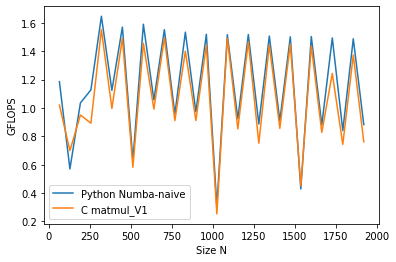

In [19]:
plt.plot(compiled_naive_gflops_curve[:,0], compiled_naive_gflops_curve[:,1], label="Python Numba-naive")
plt.plot(matmul_v1_gflops_curve[:,0], matmul_v1_gflops_curve[:,1], label="C matmul_V1")

plt.legend()
plt.gca().set_xlabel("Size N")
plt.gca().set_ylabel("GFLOPS")
plt.show()

The performance curve of matmul_v1 is very similar to the one from our Python compiled Naive version and exhibits the same behavior, indicating that the function is bandwidth-limited (default in the memory management).

---

### Matmul_v2: Inner loop accumulator

In order to lift the bandwidth limit, we need to improve our use of the system's memory hierarchy. In other words, we need to reduce and mutualize access to global memory and reuse data as much as possible as possible once they are loaded from the RAM to the different levels of CPU cache and CPU register.

One minimalistic change to our matmul_v1 function is to add a local accumulator for the inner loop sum and write the result to the C matrix only once.

In [20]:
%%writefile matmul_v2.c

#include "aux.h"
struct timeval timer;

//v1 + simple register accumulate
void matmul_v2(const float *A, const float *B, float *C, int M, int N, int K)
{
    int i,j,k;
    float acc;

    for(j = 0; j < N; j++)
        for(i = 0; i < M; i++)
        {
            acc = 0.0;
            for(k = 0; k < K; k++)
                acc += A[k*M+i] * B[j*K+k];
            C[j*M+i] = acc;
        }
}

int main(int argc, char *argv[])
{
    size_t l_size = atoi(argv[1]);
    float *A, *B, *C;

    create_matrices(&A, &B, &C, l_size, l_size, l_size);

    init_timing(&timer);
    matmul_v2(A, B, C, l_size, l_size, l_size);
    printf("%f", elapsed_time(timer));

    exit(EXIT_SUCCESS);
}

Overwriting matmul_v2.c


We evaluate the compute times and GFLOPS of this matmul_v2 implementation for all possible compilation optimization levels (None, -O1, -O2, -O3).

In [21]:
l_size = 1920

print("All computations done with size %d"%(l_size))

opt_list = ["", "-O1", "-O2", "-O3"]

for c_opt in opt_list:

    os.system("gcc aux.h aux.c matmul_v2.c -o matmul_v2 -lopenblas -lm %s"%(c_opt))
    elapsed_time_matmul_v2 = float(os.popen("./matmul_v2 %d"%(l_size)).read())
    gflops_matmul_v2 = l_size**3/1e9/elapsed_time_matmul_v2
    print ("matmul_v2 %s \t time %f s \t GFLOPS %f"%(c_opt, elapsed_time_matmul_v2, gflops_matmul_v2))

print ("Performances of v2 as a fraction of OpenBLAS SGEMM: %.2f %%"%((gflops_matmul_v2/gflops_sgemm)*100.0))

All computations done with size 1920
matmul_v2  	 time 20.441263 s 	 GFLOPS 0.346255
matmul_v2 -O1 	 time 10.308961 s 	 GFLOPS 0.686576
matmul_v2 -O2 	 time 9.214299 s 	 GFLOPS 0.768142
matmul_v2 -O3 	 time 9.442270 s 	 GFLOPS 0.749596
Performances of v2 as a fraction of OpenBLAS SGEMM: 1.16 %


Compared to matmul_v1, the performances are improved when no compilation flag is used, but it should make no major difference after -O1. This indicates that the compiler with -Ox is able to identify redundant updates of an element in the global memory and, by itself, uses a temporary variable for the accumulation and does the update only once.

As before, we plot the performance curve for matmul_v2 to observe that there is no major difference in the function behavior.

In [22]:
os.system("gcc -O2 aux.h aux.c matmul_v2.c -o matmul_v2 -lopenblas -lm")

#Actual computation of the curve, might take some time
matmul_v2_gflops_curve = perf_curve_fct_C("./matmul_v2", start=64, end=1920, size_step=64)

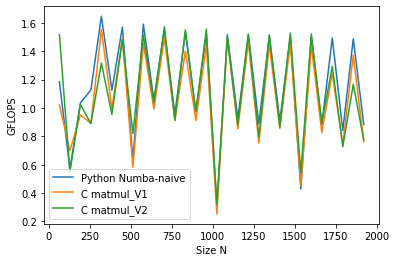

In [23]:
plt.plot(compiled_naive_gflops_curve[:,0], compiled_naive_gflops_curve[:,1], label="Python Numba-naive")
plt.plot(matmul_v1_gflops_curve[:,0], matmul_v1_gflops_curve[:,1], label="C matmul_V1")
plt.plot(matmul_v2_gflops_curve[:,0], matmul_v2_gflops_curve[:,1], label="C matmul_V2")

plt.legend()
plt.gca().set_xlabel("Size N")
plt.gca().set_ylabel("GFLOPS")
plt.show()

---
### Matmul_v3: Transposed matrix and auto-vectorization

From a memory bandwidth perspective, the main limiting aspect of our matmul v1 and v2 is that the required elements of one of the two matrices, A and B, are not continuous in the system memory.  
In the inner loop, k addresses the elements of the $i$-th row of $A$ and the elements of the $j$-th column of $B$. With our column-major convention, elements of $B$ are continuous in memory but not the elements of $A$, creating a cache-miss in the memory hierarchy.

<img src="https://github.com/Deyht/green_ai_espci/blob/main/images/memory_hierarchy_illustration.png" width="700">

One solution is then to transpose the matrix $A$ before computing the matrix multiplication. While performing the transposition adds time and increases memory usage, it allows to restore memory continuity for both $A$ and $B$ matrices. We implement this approach as matmul_v3 in the next cell.

In [24]:
%%writefile matmul_v3.c

#include "aux.h"
struct timeval timer;

//v2 + transposed A
//With the proper set of compilation optimization flags
//this function will be auto-vectorized
void matmul_v3(const float *A, const float *B, float *C, int M, int N, int K)
{
    int i,j,k;
    float *t_A = (float*) malloc(M*K*sizeof(float));
    float acc;

    for(i = 0; i < M; i++)
        for(k = 0; k < K; k++)
            t_A[i*K+k] = A[k*M+i];


    for(j = 0; j < N; j++)
        for(i = 0; i < M; i++)
        {
            acc = 0.0;
            for(k = 0; k < K; k++)
                acc += t_A[i*K+k] * B[j*K+k];
            C[j*M+i] = acc;
        }
}

int main(int argc, char *argv[])
{
    size_t l_size = atoi(argv[1]);
    float *A, *B, *C;

    create_matrices(&A, &B, &C, l_size, l_size, l_size);

    init_timing(&timer);
    matmul_v3(A, B, C, l_size, l_size, l_size);
    printf("%f", elapsed_time(timer));

    exit(EXIT_SUCCESS);
}

Overwriting matmul_v3.c


As before we test the different levels of -Ox optimization.

In [25]:
l_size = 1920

print("All computations done with size %d"%(l_size))

opt_list = ["", "-O1", "-O2", "-O3"]

for c_opt in opt_list:

    os.system("gcc aux.h aux.c matmul_v3.c -o matmul_v3 -lopenblas -lm %s"%(c_opt))
    elapsed_time_matmul_v3 = float(os.popen("./matmul_v3 %d"%(l_size)).read())
    gflops_matmul_v3 = l_size**3/1e9/elapsed_time_matmul_v3
    print ("matmul_v3 %s \t time %f s \t GFLOPS %f"%(c_opt, elapsed_time_matmul_v3, gflops_matmul_v3))

print ("Performances of v3 as a fraction of OpenBLAS SGEMM: %.2f %%"%((gflops_matmul_v3/gflops_sgemm)*100.0))

All computations done with size 1920
matmul_v3  	 time 18.611336 s 	 GFLOPS 0.380300
matmul_v3 -O1 	 time 4.555838 s 	 GFLOPS 1.553586
matmul_v3 -O2 	 time 4.522629 s 	 GFLOPS 1.564994
matmul_v3 -O3 	 time 4.447184 s 	 GFLOPS 1.591544
Performances of v3 as a fraction of OpenBLAS SGEMM: 2.47 %


This version results in a significant speedup compared to the previous two, even without compile optimization.

In addition, there is a strong improvement once any optimization flag is added. This is the result of the compiler identifying that we perform element-wise multiplications of two vectors of data that are continuous in memory. The compiler then chose to express these operations as vectorized SIMD instructions based on the instruction sets supported by the CPU. This behavior is called auto-vectorization.

We now try to explicitly set some additional optimization flags to increase the performance even more.

In [26]:
l_size = 1920

print("All computations done with size %d"%(l_size))

base_opt = "-O3"
#Depending on your system and gcc version, best performances might be achieved with either -O2 or -O3

opt_list = ["-march=native ", "-funroll-loops ", "-ffast-math ",
           "-march=native -funroll-loops",
           "-ffast-math -funroll-loops",
           "-ffast-math -march=native",
           "-ffast-math -march=native -funroll-loops"]

for c_opt in opt_list:

    os.system("gcc aux.h aux.c matmul_v3.c -o matmul_v3 -lopenblas -lm %s %s"%(base_opt, c_opt))
    elapsed_time_matmul_v3 = float(os.popen("./matmul_v3 %d"%(l_size)).read())
    gflops_matmul_v3 = l_size**3/1e9/elapsed_time_matmul_v3
    print ("matmul_v3 %s %-44s time %.4f s \t GFLOPS %f"%(base_opt, c_opt, elapsed_time_matmul_v3, gflops_matmul_v3))

print ("Performances of v3 as a fraction of OpenBLAS SGEMM: %.2f %%"%((gflops_matmul_v3/gflops_sgemm)*100.0))

All computations done with size 1920
matmul_v3 -O3 -march=native                                time 4.3097 s 	 GFLOPS 1.642332
matmul_v3 -O3 -funroll-loops                               time 4.3630 s 	 GFLOPS 1.622269
matmul_v3 -O3 -ffast-math                                  time 1.0940 s 	 GFLOPS 6.469905
matmul_v3 -O3 -march=native -funroll-loops                 time 4.3258 s 	 GFLOPS 1.636216
matmul_v3 -O3 -ffast-math -funroll-loops                   time 1.0710 s 	 GFLOPS 6.608728
matmul_v3 -O3 -ffast-math -march=native                    time 0.5665 s 	 GFLOPS 12.494484
matmul_v3 -O3 -ffast-math -march=native -funroll-loops     time 0.5156 s 	 GFLOPS 13.726361
Performances of v3 as a fraction of OpenBLAS SGEMM: 21.32 %


While the combination of the three options should grant the best performance, it is strongly dependent on the system. In our testing environment, we reached 16.6% of OpenBLAS SGEMM performances with this version. In the next cell, we trace the performance curve using our best compilation setup, which must be adapted for your own system based on the results from the previous cell.

In [27]:
os.system("gcc aux.h aux.c matmul_v3.c -o matmul_v3 -lopenblas -lm -O3 -ffast-math -march=native -funroll-loops")

#Actual computation of the curve, might take some time
matmul_v3_gflops_curve = perf_curve_fct_C("./matmul_v3", start=64, end=1920, size_step=64)

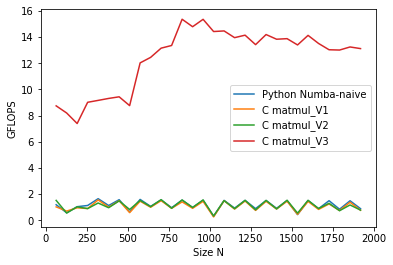

In [28]:
plt.plot(compiled_naive_gflops_curve[:,0], compiled_naive_gflops_curve[:,1], label="Python Numba-naive")
plt.plot(matmul_v1_gflops_curve[:,0], matmul_v1_gflops_curve[:,1], label="C matmul_V1")
plt.plot(matmul_v2_gflops_curve[:,0], matmul_v2_gflops_curve[:,1], label="C matmul_V2")
plt.plot(matmul_v3_gflops_curve[:,0], matmul_v3_gflops_curve[:,1], label="C matmul_V3")

plt.legend()
plt.gca().set_xlabel("Size N")
plt.gca().set_ylabel("GFLOPS")
plt.show()

The performance curve of matmul_v3 is much higher than those of previous versions. It is also much more stable, but it still loses performance for larger problem sizes. This is again a sign of bandwidth limitation, but it is no longer caused by a cache miss from L3 to RAM. To gain more performance, we will need to start optimizing CPU cache usage.

### Matmul_v4: Manual vectorization using GCC SIMD build-in vector support


While auto-vectorization is a powerful feature of the compiler, we will see how we can match the performances of matmul_v3 with a manual vectorized implementation that makes use of built-in gcc vector data structures that allow abstract SIMD operations using the AVX2 instruction set. For example, the following line declares a type vector composed of 32 Bytes (or 256 Bits, which is the default vector size for AVX2), which can store 8 simple precision floating point values of 4 Bytes/32 bits each.
```
typedef float vec __attribute__ ((vector_size(32));
```
While it is possible to invoke the vector multiplication instruction manually, when doing operations on vector data, the compiler will automatically use the corresponding vectorized FMA (Fused Multiply Add) operation.

While this specific implementation would not necessarily be portable to another compiler, equivalent data types are available to reproduce the same implementation principles. Overall, this type of low-level optimization starts to be hardware-specific (brand of CPU, specific architecture, etc).

The following cell implements matmul_v4 that creates vectorized versions of $A^T$ and $B$ and fills them with the corresponding data. The element-wise products are performed vector-wise using an implicit vectorized FMA instruction.

In [29]:
%%writefile matmul_v4.c

#include "aux.h"
struct timeval timer;

//v3 + manual vectorization through memory aligned SIMD operations
//Note, require C11 ISO, not compatible with C99 while auto vectorization is compatible

// Define a memory aligned vector of 8 floats (32 bytes wide vector, ie 256 bits)
typedef float vec __attribute__ (( vector_size(32) ));

void matmul_v4(const float *A, const float *B, float *C, int M, int N, int K)
{
    int i,j,k;
    // Rounded number of 8-element vec in a K
    if(K % 8 != 0)
    {
        printf("Error, mismatch between matrix size and kernel size");
        exit(EXIT_FAILURE);
    }

    int n_K = K/8;


    vec *a = (vec*) aligned_alloc(32,M*n_K*32);
    vec *b = (vec*) aligned_alloc(32,N*n_K*32);

    for(i = 0; i < M; i++)
        for(j = 0; j < K; j++)
            a[i*n_K + j/8][j%8] = A[j*M+i];

    for(i = 0; i < N; i++)
        for(j = 0; j < K; j++)
            b[i*n_K + j/8][j%8] = B[i*K+j];


    for(j = 0; j < N; j++)
        for(i = 0; i < M; i++)
        {
            vec acc = {0.0f, 0.0f, 0.0f, 0.0f, 0.0f, 0.0f, 0.0f, 0.0f};
            for(k = 0; k < n_K; k++)
                acc += a[i*n_K+k] * b[j*n_K+k];

            for(k = 0; k < 8; k++)
                C[j*M+i] += acc[k];
        }
}


int main(int argc, char *argv[])
{
    size_t l_size = atoi(argv[1]);
    float *A, *B, *C;

    create_matrices(&A, &B, &C, l_size, l_size, l_size);

    init_timing(&timer);
    matmul_v4(A, B, C, l_size, l_size, l_size);
    printf("%f", elapsed_time(timer));

    exit(EXIT_SUCCESS);
}

Overwriting matmul_v4.c


In [30]:
l_size = 1920

print("All computations done with size %d"%(l_size))

opt_list = ["", "-O1", "-O2", "-O3"]

for c_opt in opt_list:

    os.system("gcc aux.h aux.c matmul_v4.c -o matmul_v4 -lopenblas -lm %s"%(c_opt))
    elapsed_time_matmul_v4 = float(os.popen("./matmul_v4 %d"%(l_size)).read())
    gflops_matmul_v4 = l_size**3/1e9/elapsed_time_matmul_v4
    print ("matmul_v4 %s \t time %f s \t GFLOPS %f"%(c_opt, elapsed_time_matmul_v4, gflops_matmul_v4))

print ("Performances of v4 as a fraction of OpenBLAS SGEMM: %.2f %%"%((gflops_matmul_v4/gflops_sgemm)*100.0))

All computations done with size 1920
matmul_v4  	 time 12.925293 s 	 GFLOPS 0.547600
matmul_v4 -O1 	 time 2.417618 s 	 GFLOPS 2.927629
matmul_v4 -O2 	 time 2.230194 s 	 GFLOPS 3.173665
matmul_v4 -O3 	 time 2.405451 s 	 GFLOPS 2.942437
Performances of v4 as a fraction of OpenBLAS SGEMM: 4.57 %


In [31]:
l_size = 1920

os.system("gcc aux.h aux.c matmul_v4.c -o matmul_v4 -lopenblas -lm -O3 -ffast-math -march=native -funroll-loops")
elapsed_time_matmul_v4 = float(os.popen("./matmul_v4 %d"%(l_size)).read())
gflops_matmul_v4 = l_size**3/1e9/elapsed_time_matmul_v4
print ("matmul_v4 \t time %f s \t GFLOPS %f"%(elapsed_time_matmul_v4, gflops_matmul_v4))

print ("Performances of v4 as a fraction of OpenBLAS SGEMM: %.2f %%"%((gflops_matmul_v4/gflops_sgemm)*100.0))

matmul_v4 	 time 0.551537 s 	 GFLOPS 12.833025
Performances of v4 as a fraction of OpenBLAS SGEMM: 19.94 %


Compared to matmul_v3 we doubled the GFLOPS, still using only -O2 and -O3, without advanced compilation options. With the advanced options, matmul_v3 and matmul_v4 achieve the same performances. The reasons are detailed after the computation of the performance curve.

In [32]:
os.system("gcc aux.h aux.c matmul_v4.c -o matmul_v4 -lopenblas -lm -O3 -ffast-math -march=native -funroll-loops")

#Actual computation of the curve, might take some time
matmul_v4_gflops_curve = perf_curve_fct_C("./matmul_v4", start=64, end=1920, size_step=64)

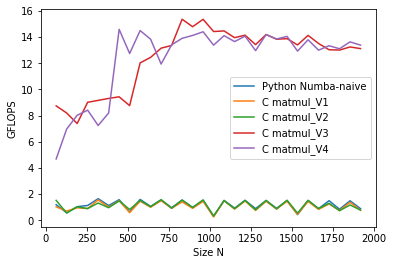

In [33]:
plt.plot(compiled_naive_gflops_curve[:,0], compiled_naive_gflops_curve[:,1], label="Python Numba-naive")
plt.plot(matmul_v1_gflops_curve[:,0], matmul_v1_gflops_curve[:,1], label="C matmul_V1")
plt.plot(matmul_v2_gflops_curve[:,0], matmul_v2_gflops_curve[:,1], label="C matmul_V2")
plt.plot(matmul_v3_gflops_curve[:,0], matmul_v3_gflops_curve[:,1], label="C matmul_V3")
plt.plot(matmul_v4_gflops_curve[:,0], matmul_v4_gflops_curve[:,1], label="C matmul_V4")

plt.legend()
plt.gca().set_xlabel("Size N")
plt.gca().set_ylabel("GFLOPS")
plt.show()

As expected, matmul_v4 and matmul_v3 have the same performance curve. This means that we have likely manually reproduced the auto-vectorization behavior from the compiler when using all the optimization flags.

The comparison between matmul_v4 and matmul_v3 serves two objectives:
- Illustrate that it is possible to reach high performances with relatively naive implementations without low-level optimization by relying on the compiler.
- Serves as an example of how vectorized data types work, considering they are necessary to reach even greater performances through low-level CPU cache optimization.

---
### Matmul_v5: optimum data reuse with in-register vectorized kernel

We will now shift our approach to the problem. Instead of thinking from the RAM to the cache, we will try to identify how we can fit the core operations of our matmul algorithm inside the fastest cache level, namely the CPU registry. We will then scale up by optimizing the loading of the CPU register from progressively slower level of CPU caches.

In the previous approach, we fixed a column of $B$ (most outer loop) to optimize its reuse and then loop (intermediate loop) over the rows of the transposed version of A. However, with this approach, it is obvious that we need to reload the rows of $A$ as many times as we have columns of $B$, leading to multiple loadings of the same data. In addition, as soon as either one row or one column is larger than a given level of cache, we need multiple copies over this cache every time we reload the data.

In contrast, the core of the new implementation is a low-level kernel that will process a $k_h$ set of rows from $A$ and a $k_w$ set of columns from $B$ and compute all the cross products and sums to fill the corresponding sub-part of $C$. The kernel will then take the $k_h$ elements from the first column of the subset of $A$ and the $k_w$ elements from the first row of the subset of $B$. The kernel then computes the element-wise product of these two vectors and adds the result in the appropriate elements of $C$. 

<img src="https://github.com/Deyht/green_ai_espci/blob/main/images/kernel_v5_illustration.png" width="800">

With this approach, we have effectively considered all the computations in which the loaded elements are involved without the need to load them again later. Now, to properly fill the $C$ matrix, we need to repeat this operation over the $K$ dimension for all columns of $A$ and rows of $B$ in the selected subset to accumulate the products of all the required elements. Once the sub-part of the $C$ matrix is filled with the final value, we can repeat this approach for another subset of rows from $A$ and columns from $B$.

However, all this strategy would be useless if individual vectors remain too large to fit in the fastest level of cache. Our objective is to run the kernel inside the CPU register. On most modern CPUs that support AVX instructions, the register can store up to 16 vector data structures of 4 Bytes each. In addition, FMA instructions can run partially in parallel, meaning that we need to compute on a minimum number of registers to saturate computing performances. Here, we estimate that parallel FMA instructions on 10 registers are enough to saturate the execution port. Considering that we need two vectors for intermediate computations, we wille build a kernel logic that makes use of $2\times6=12$ vectors (the size of the $C$ sub-matrix and subset of rows and columns for $A$ and $B$, respectively) for a total of 14 vectors. We consider vectors aligned with the elements in memory, meaning that our kernel will work on an area corresponding to $k_h=2\times8=16$ rows of $A$ and $k_w=6$ columns of $B$.

For each position $k$, the kernel must contain two loops:  
1) A loop over the 6 width kernel element of matrix B. At each step, the current value must be broadcasted to a vector with 8 identical values.  
2) A loop over the the height kernel element of matrix A. This time the 16 elements are decomposed over 2 vectors.  
3) The two current vectors can be multiplied to accumulate 8 products in the kernel corresponding to C[i:i+8,j] += A[i:i+8] * B[j]

Finally, this kernel must be called in a double loop for all its possible positions in C.

In [34]:
%%writefile matmul_v5.c

#include "aux.h"
struct timeval timer;

//Matmul using FMA operation on a sub-part of C and optimizing the cache usage
//No need for transposition in this version as most of the work is done in cache anyway

// Define a memory aligned vector of 8 floats (32 bytes wide vector, ie 256 bits)
typedef float vec __attribute__ (( vector_size(32) ));

#define ker_w 6
#define ker_h 16
//ker_h must be a multiple of 8

void kernel(const float *_a, const float *_b, float *_c,
    int M, int N, int K, int i, int j, int k_start, int k_stop)
{
    int k, b_m, b_n, l;
    float val;
    //declared in CPU register
    vec t[ker_h/8][ker_w] = {};

    for(k = k_start; k < k_stop; k++)
    {
        for(b_n = 0; b_n < ker_w; b_n++)
        {
            //brodcast B value to the full vector
            val = _b[(i+b_n)*K+k];
            vec beta = {val, val, val, val, val, val, val, val};

            for(b_m = 0; b_m < ker_h/8; b_m++)
            {
                vec alpha;
                for(l = 0; l < 8; l++)
                    alpha[l] = _a[j+k*M+b_m*8+l];
                t[b_m][b_n] += alpha * beta; // converts to an fma
            }
        }
    }

    // write the results back to C
    for(b_n = 0; b_n < ker_w; b_n++)
        for(b_m = 0; b_m < ker_h/8; b_m++)
            for(l = 0; l < 8; l++)
                _c[j+(i+b_n)*M+b_m*8+l] += t[b_m][b_n][l];
}


void matmul_v5(const float *A, const float *B, float *C, int M, int N, int K)
{
    int i,j,k;

    if(M % ker_h != 0 || N % ker_w != 0)
    {
        printf("Error, mismatch between matrix size and kernel size");
        exit(EXIT_FAILURE);
    }


    for(j = 0; j < M; j += ker_h)
        for(i = 0; i < N; i += ker_w)
            kernel(A, B, C, M, N, K, i, j, 0, K);
}


int main(int argc, char *argv[])
{
    size_t l_size = atoi(argv[1]);
    float *A, *B, *C;

    create_matrices(&A, &B, &C, l_size, l_size, l_size);

    init_timing(&timer);
    matmul_v5(A, B, C, l_size, l_size, l_size);
    printf("%f", elapsed_time(timer));

    exit(EXIT_SUCCESS);
}

Overwriting matmul_v5.c


In [35]:
l_size = 48*40 #Must be a multiple of 48 for the kernel to work

print("All computations done with size %d"%(l_size))

opt_list = ["", "-O1", "-O2", "-O3"]

for c_opt in opt_list:

    os.system("gcc aux.h aux.c matmul_v5.c -o matmul_v5 -lopenblas -lm %s"%(c_opt))
    elapsed_time_matmul_v5 = float(os.popen("./matmul_v5 %d"%(l_size)).read())
    gflops_matmul_v5 = l_size**3/1e9/elapsed_time_matmul_v5
    print ("matmul_v5 %s \t time %f s \t GFLOPS %f"%(c_opt, elapsed_time_matmul_v5, gflops_matmul_v5))

print ("Performances of v5 as a fraction of OpenBLAS SGEMM: %.2f %%"%((gflops_matmul_v5/gflops_sgemm)*100.0))

All computations done with size 1920
matmul_v5  	 time 22.620436 s 	 GFLOPS 0.312898
matmul_v5 -O1 	 time 9.949720 s 	 GFLOPS 0.711366
matmul_v5 -O2 	 time 6.005387 s 	 GFLOPS 1.178590
matmul_v5 -O3 	 time 4.637199 s 	 GFLOPS 1.526328
Performances of v5 as a fraction of OpenBLAS SGEMM: 2.37 %


In [36]:
l_size = 48*40

os.system("gcc aux.h aux.c matmul_v5.c -o matmul_v5 -lopenblas -lm -O3 -ffast-math -march=native -funroll-loops")
elapsed_time_matmul_v5 = float(os.popen("./matmul_v5 %d"%(l_size)).read())
gflops_matmul_v5 = l_size**3/1e9/elapsed_time_matmul_v5
print ("matmul_v5 \t time %f s \t GFLOPS %f"%(elapsed_time_matmul_v5, gflops_matmul_v5))

print ("Performances of v5 as a fraction of OpenBLAS SGEMM: %.2f %%"%((gflops_matmul_v5/gflops_sgemm)*100.0))

matmul_v5 	 time 0.340188 s 	 GFLOPS 20.805813
Performances of v5 as a fraction of OpenBLAS SGEMM: 32.32 %


In [37]:
os.system("gcc aux.h aux.c matmul_v5.c -o matmul_v5 -lopenblas -lm -O3 -ffast-math -march=native -funroll-loops")

#Actual computation of the curve, might take some time
matmul_v5_gflops_curve = perf_curve_fct_C("./matmul_v5", start=96, end=3072, size_step=96)

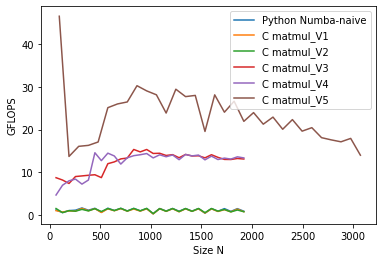

In [38]:
plt.plot(compiled_naive_gflops_curve[:,0], compiled_naive_gflops_curve[:,1], label="Python Numba-naive")
plt.plot(matmul_v1_gflops_curve[:,0], matmul_v1_gflops_curve[:,1], label="C matmul_V1")
plt.plot(matmul_v2_gflops_curve[:,0], matmul_v2_gflops_curve[:,1], label="C matmul_V2")
plt.plot(matmul_v3_gflops_curve[:,0], matmul_v3_gflops_curve[:,1], label="C matmul_V3")
plt.plot(matmul_v4_gflops_curve[:,0], matmul_v4_gflops_curve[:,1], label="C matmul_V4")
plt.plot(matmul_v5_gflops_curve[:,0], matmul_v5_gflops_curve[:,1], label="C matmul_V5")

plt.legend()
plt.gca().set_xlabel("Size N")
plt.gca().set_ylabel("GFLOPS")
plt.show()

---
### Matmul_v6: Blocked matrix multiplication with register kernel

The previous version is still bandwidth limited. To further optimize we must maximize the reuse of data loaded in the different CPU caches by working on blocks of the matrices.

Our biggest cache miss is the frequent change of columns in $A$ through the loop over $K$. Our fastest L1 cache must contain as much columns of $A$ as possible. This will also define the number of lines in $B$. We defined $BDimK$ the number of columns of $A$.

Our second cache miss is for the change in columns in $B$ through the loop over N. This one will mostly define our L2 cache. We define $BDimN$ as the number of columns from B.

Finally, we want to cache rows of $A$ in a way that fill the L3 cache considering the two previous dimensions. We define $BDimN$ as the number of row from $A$.

Each block must be a multiple of the kernel size, so a loop over all the kernel position in the block can be used.

<img src="https://github.com/Deyht/green_ai_espci/blob/main/images/blocked_matmul_v6_illustration.png" width="500">


In [39]:
%%writefile matmul_v6.c

#include "aux.h"
struct timeval timer;

//Matmul using FMA operation on a sub-part of C and optimizing the cache usage
//No need for transposition in this version as most of the work is done in cache anyway

// Define a memory aligned vector of 8 floats (32 bytes wide vector, ie 256 bits)
typedef float vec __attribute__ (( vector_size(32) ));

#define ker_w 6
#define ker_h 16
//ker_h must be a multiple of 8


void kernel(const float *_a, const float *_b, float *_c,
    int M, int N, int K, int i, int j, int k_start, int k_stop)
{
    int k, b_m, b_n, l;
    float val;
    //declared in CPU register
    vec t[ker_h/8][ker_w] = {};

    for(k = k_start; k < k_stop; k++)
    {
        for(b_n = 0; b_n < ker_w; b_n++)
        {
            //brodcast B value to the full vector
            val = _b[(i+b_n)*K+k];
            vec beta = {val, val, val, val, val, val, val, val};

            for(b_m = 0; b_m < ker_h/8; b_m++)
            {
                vec alpha;
                for(l = 0; l < 8; l++)
                    alpha[l] = _a[j+k*M+b_m*8+l];
                t[b_m][b_n] += alpha * beta; // converts to an fma
            }
        }
    }

    // write the results back to C
    for(b_n = 0; b_n < ker_w; b_n++)
        for(b_m = 0; b_m < ker_h/8; b_m++)
            for(l = 0; l < 8; l++)
                _c[j+(i+b_n)*M+b_m*8+l] += t[b_m][b_n][l];
}


//V4 but with blocking decomposition to successively load sub parts of A and B
//into L2 and L1 cache for maximum reuse. Maximizing the achievable memory bandwidth

void matmul_v6(const float *A, const float *B, float *C, int M, int N, int K)
{
    int i,j,k;

    const int l3 = 64; //Number of rows from A
    const int l2 = 120; //Number of columns from B
    const int l1 = 120; //Number of columns from A

    if(M % ker_h != 0 || N % ker_w != 0 || l2 % ker_w != 0 || l3 % ker_h != 0)
    {
        printf("Error, mismatch between matrix size and kernel size");
        exit(EXIT_FAILURE);
    }

    int i1, i2, i3;

    for(i3 = 0; i3 < M; i3 += l3)
        for(i2 = 0; i2 < N; i2 += l2)
            for(i1 = 0; i1 < K; i1 += l1)
                for(j = i3; j < fmin(i3+l3,M); j += ker_h)
                    for(i = i2; i < fmin(i2+l2,N); i += ker_w)
                        kernel(A, B, C, M, N, K, i, j, i1, fmin(i1+l1,K));
}


int main(int argc, char *argv[])
{
    size_t l_size = atoi(argv[1]);
    float *A, *B, *C;

    create_matrices(&A, &B, &C, l_size, l_size, l_size);

    init_timing(&timer);
    matmul_v6(A, B, C, l_size, l_size, l_size);
    printf("%f", elapsed_time(timer));

    exit(EXIT_SUCCESS);
}

Overwriting matmul_v6.c


In [40]:
l_size = 48*40 #Must be a multiple of 48 for the kernel to work

print("All computations done with size %d"%(l_size))

opt_list = ["", "-O1", "-O2", "-O3"]

for c_opt in opt_list:

    os.system("gcc aux.h aux.c matmul_v6.c -o matmul_v6 -lopenblas -lm %s"%(c_opt))
    elapsed_time_matmul_v6 = float(os.popen("./matmul_v6 %d"%(l_size)).read())
    gflops_matmul_v6 = l_size**3/1e9/elapsed_time_matmul_v6
    print ("matmul_v6 %s \t time %f s \t GFLOPS %f"%(c_opt, elapsed_time_matmul_v6, gflops_matmul_v6))

print ("Performances of v6 as a fraction of OpenBLAS SGEMM: %.2f %%"%((gflops_matmul_v6/gflops_sgemm)*100.0))

All computations done with size 1920
matmul_v6  	 time 22.753428 s 	 GFLOPS 0.311069
matmul_v6 -O1 	 time 10.049287 s 	 GFLOPS 0.704317
matmul_v6 -O2 	 time 6.013795 s 	 GFLOPS 1.176942
matmul_v6 -O3 	 time 4.860477 s 	 GFLOPS 1.456213
Performances of v6 as a fraction of OpenBLAS SGEMM: 2.26 %


In [41]:
l_size = 48*40

os.system("gcc aux.h aux.c matmul_v6.c -o matmul_v6 -lopenblas -lm -O3 -ffast-math -march=native -funroll-loops")
elapsed_time_matmul_v6 = float(os.popen("./matmul_v6 %d"%(l_size)).read())
gflops_matmul_v6 = l_size**3/1e9/elapsed_time_matmul_v6
print ("matmul_v6 \t time %f s \t GFLOPS %f"%(elapsed_time_matmul_v6, gflops_matmul_v6))

print ("Performances of v6 as a fraction of OpenBLAS SGEMM: %.2f %%"%((gflops_matmul_v6/gflops_sgemm)*100.0))

matmul_v6 	 time 0.257047 s 	 GFLOPS 27.535385
Performances of v6 as a fraction of OpenBLAS SGEMM: 42.78 %


In [ ]:
os.system("gcc aux.h aux.c matmul_v6.c -o matmul_v6 -lopenblas -lm -O3 -ffast-math -march=native -funroll-loops")

#Actual computation of the curve, might take some time
matmul_v6_gflops_curve = perf_curve_fct_C("./matmul_v6", start=96, end=3072, size_step=96)

In [ ]:
plt.plot(compiled_naive_gflops_curve[:,0], compiled_naive_gflops_curve[:,1], label="Python Numba-naive")
plt.plot(matmul_v1_gflops_curve[:,0], matmul_v1_gflops_curve[:,1], label="C matmul_V1")
plt.plot(matmul_v2_gflops_curve[:,0], matmul_v2_gflops_curve[:,1], label="C matmul_V2")
plt.plot(matmul_v3_gflops_curve[:,0], matmul_v3_gflops_curve[:,1], label="C matmul_V3")
plt.plot(matmul_v4_gflops_curve[:,0], matmul_v4_gflops_curve[:,1], label="C matmul_V4")
plt.plot(matmul_v5_gflops_curve[:,0], matmul_v5_gflops_curve[:,1], label="C matmul_V5")
plt.plot(matmul_v6_gflops_curve[:,0], matmul_v6_gflops_curve[:,1], label="C matmul_V6")

plt.legend()
plt.gca().set_xlabel("Size N")
plt.gca().set_ylabel("GFLOPS")
plt.show()

This time, we are very close to a performance curve that maintains its performances over a wide range of matrix sizes, indicating that we likely reached a regime of computing limitation. Now, we can plot the actual performance curve for the OpenBLAS SGEMM version for comparison.

In [ ]:
sgemm_gflops_curve = perf_curve_fct_C("./matmul_blas", start=96, end=3072, size_step=96)

In [ ]:
plt.plot(compiled_naive_gflops_curve[:,0], compiled_naive_gflops_curve[:,1], label="Python Numba-naive")
plt.plot(matmul_v1_gflops_curve[:,0], matmul_v1_gflops_curve[:,1], label="C matmul_V1")
plt.plot(matmul_v2_gflops_curve[:,0], matmul_v2_gflops_curve[:,1], label="C matmul_V2")
plt.plot(matmul_v3_gflops_curve[:,0], matmul_v3_gflops_curve[:,1], label="C matmul_V3")
plt.plot(matmul_v4_gflops_curve[:,0], matmul_v4_gflops_curve[:,1], label="C matmul_V4")
plt.plot(matmul_v5_gflops_curve[:,0], matmul_v5_gflops_curve[:,1], label="C matmul_V5")
plt.plot(matmul_v6_gflops_curve[:,0], matmul_v6_gflops_curve[:,1], label="C matmul_V6")
plt.plot(sgemm_gflops_curve[:,0], sgemm_gflops_curve[:,1], label="OpenBLAS SGEMM")

plt.legend()
plt.gca().set_xlabel("Size N")
plt.gca().set_ylabel("GFLOPS")
plt.show()

Bridging the remaining gap between matmul_v6 and the OpenBLAS version of SGEMM would require several small adjustments like rewriting the kernel without any loops (listing all operations explicitly), ensure memorry alignement, or having specific kernel and block sizes depending on the global matrices sizes. OpenBLAS does exactly size with various pre-compiled versions of optimized matrix multiplication that are selected depending on the context and problem shape, all hidden behind a single call to SGEMM.

---

## OpenMP parallelization

In this part we evaluate how we modify our matmul_v6 imlplementation so it is parallelized of multiple threads using OpenMP. First, we start by evaluating the scaling of OpenBLAS version for reference.

In [ ]:
#Must be set to 2 if runing in colab

os.environ["OMP_NUM_THREADS"] = "6"
os.environ["OPENBLAS_NUM_THREADS"] = "6"
import numpy as np

para_sgemm_gflops_curve = perf_curve_fct_C("./matmul_blas", start=96, end=3072, size_step=96)

In [ ]:
plt.plot(sgemm_gflops_curve[:,0], sgemm_gflops_curve[:,1], c="C0", ls="--", label="OpenBLAS SGEMM")
plt.plot(para_sgemm_gflops_curve[:,0], para_sgemm_gflops_curve[:,1], c="C0", label="OpenBLAS SGEMM para")

plt.legend()
plt.gca().set_xlabel("Size N")
plt.gca().set_ylabel("GFLOPS")
plt.show()

OpenMP allow to parallelize the execution of code on shared memory systems. For a detailed introduction of OpenMP capabilities, we recommand reading Idris course on [OpenMP](http://www.idris.fr/media/formations/openmp/idris_openmp_cours-v2.11.pdf). In summary, OpenMP wille rely on the master thread of the program to create parallel zones. All the functionalities of OpenMP are accessible through "pre-processing" directives that are automatically interpreted during compilation and replace with actual lines of codes and instructions. For the programme, this formalism allows to easily compile a program with or without the OpenMP directives taken into acount by the compiler.

One of the simplest way of using OpenMP to accelerate a computation is to use a loop where operations are independant and distribute its iterations over multiple threads/cores. Here we can follow this principle to parallelize over the most outer loop of our blocked matmul implementation.

The number of threads in use is defined by a environmental variable (OMP_NUM_THREADS), so it is not necessary to recompile in order to change the number of threads.

<img src="https://github.com/Deyht/green_ai_espci/blob/main/images/openmp_loop_example.png" align="left" width="400"> 



In [ ]:
%%writefile matmul_v6_para.c

#include "aux.h"
struct timeval timer;

//Matmul using FMA operation on a sub-part of C and optimizing the cache usage
//No need for transposition in this version as most of the work is done in cache anyway

// Define a memory aligned vector type of 8 floats (32 bit)
typedef float vec __attribute__ (( vector_size(32) ));

#define ker_w 6
#define ker_h 16
//ker_h must be a multiple of 8

void kernel(const float *_a, const float *_b, float *_c,
    int M, int N, int K, int i, int j, int k_start, int k_stop)
{
    int k, b_m, b_n, l;
    float val;
    //declared in CPU register
    vec t[ker_h/8][ker_w] = {};

    for(k = k_start; k < k_stop; k++)
    {
        for(b_n = 0; b_n < ker_w; b_n++)
        {
            //brodcast B value to the full vector
            val = _b[(i+b_n)*K+k];
            vec beta = {val, val, val, val, val, val, val, val};

            for(b_m = 0; b_m < ker_h/8; b_m++)
            {
                vec alpha;
                for(l = 0; l < 8; l++)
                    alpha[l] = _a[j+k*M+b_m*8+l];
                t[b_m][b_n] += alpha * beta; // converts to an fma
            }
        }
    }

    // write the results back to C
    for(b_n = 0; b_n < ker_w; b_n++)
        for(b_m = 0; b_m < ker_h/8; b_m++)
            for(l = 0; l < 8; l++)
                _c[j+(i+b_n)*M+b_m*8+l] += t[b_m][b_n][l];
}


//V4 but with blocking decomposition to successively load sub parts of A and B
//into L2 and L1 cache for maximum reuse. Maximizing the achievable memory bandwidth

void matmul_v6(const float *A, const float *B, float *C, int M, int N, int K)
{
    int i,j,k;

    const int l3 = 64; //Number of rows from A
    const int l2 = 120; //Number of columns from B
    const int l1 = 240; //Number of columns from A

    if(M % ker_h != 0 || N % ker_w != 0 || l2 % ker_w != 0 || l3 % ker_h != 0)
    {
        printf("Error, mismatch between matrix size and kernel size");
        exit(EXIT_FAILURE);
    }

    int i1, i2, i3;

    #pragma omp parallel for schedule(dynamic, 1) private(i3,i2,i1,i,j)
    for(i3 = 0; i3 < M; i3 += l3)
        for(i2 = 0; i2 < N; i2 += l2)
            for(i1 = 0; i1 < K; i1 += l1)
                for(j = i3; j < fmin(i3+l3,M); j += ker_h)
                    for(i = i2; i < fmin(i2+l2,N); i += ker_w)
                        kernel(A, B, C, M, N, K, i, j, i1, fmin(i1+l1,K));
}


int main(int argc, char *argv[])
{
    size_t l_size = atoi(argv[1]);
    float *A, *B, *C;

    create_matrices(&A, &B, &C, l_size, l_size, l_size);

    init_timing(&timer);
    matmul_v6(A, B, C, l_size, l_size, l_size);
    printf("%f", elapsed_time(timer));

    exit(EXIT_SUCCESS);
}

To take into account OpenMP directives (otherwise ignore by the pre-processor) we must add -fopenmp to the compilation line.

In [ ]:
os.system("gcc aux.h aux.c matmul_v6_para.c -o matmul_v6_para -fopenmp -lopenblas -lm -O3 -ffast-math -march=native -funroll-loops")

#Actual computation of the curve, might take some time
para_matmul_v6_gflops_curve = perf_curve_fct_C("./matmul_v6_para", start=96, end=3072, size_step=96)

In [ ]:
plt.plot(sgemm_gflops_curve[:,0], sgemm_gflops_curve[:,1], c="C0", ls="--", label="OpenBLAS SGEMM")
plt.plot(para_sgemm_gflops_curve[:,0], para_sgemm_gflops_curve[:,1], c="C0", label="OpenBLAS SGEMM para")
plt.plot(matmul_v6_gflops_curve[:,0], matmul_v6_gflops_curve[:,1], c="C1", ls="--", label="C matmul_V6")
plt.plot(para_matmul_v6_gflops_curve[:,0], para_matmul_v6_gflops_curve[:,1], c="C1", label="matmul_v6_para")

plt.legend()
plt.gca().set_xlabel("Size N")
plt.gca().set_ylabel("GFLOPS")
plt.show()

We see that our implementation scales properly when using less threads than phisical cores on our system, which is another indication that we properly use the memory hierarchy, especially considering that L2 and L1 levels of cache are core specific. A secondary effect of parallelization is that it breaks the global problem into smaller pieces, which is why we usually don't need more advanced implementation of the matrix multiplication algorithme as the sub-probrlem handled by a single core is most likely too small for it to positively impact performances.

Now we test how both our matmu_v6 and OpenBLAS scales by computing the speedup as a function of the number of threads.

In [ ]:
def para_scaling_curve_fct_C(line_fct, l_size, nb_threads):

    os.environ["OMP_NUM_THREADS"] = "1"
    os.environ["OPENBLAS_NUM_THREADS"] = "1"

    time_ref = float(os.popen("%s %d"%(line_fct, l_size)).read())

    speedup_curve = np.zeros((nb_threads,2))
    speedup_curve[0,:] = 1

    for n_th in range(2,nb_threads+1):

        os.environ["OMP_NUM_THREADS"] = "%d"%(n_th)
        os.environ["OPENBLAS_NUM_THREADS"] = "%d"%(n_th)

        elapsed_time = float(os.popen("%s %d"%(line_fct, l_size)).read())

        speedup_curve[n_th-1,0] = n_th
        speedup_curve[n_th-1,1] = time_ref/elapsed_time

    return speedup_curve

In [ ]:
para_matmul_v6_speedup_curve = para_scaling_curve_fct_C("./matmul_v6_para", 1920, 12)
para_sgemm_speedup_curve = para_scaling_curve_fct_C("./matmul_blas", 1920, 12)

In [ ]:
plt.plot(para_sgemm_speedup_curve[:,0], para_sgemm_speedup_curve[:,1], c="C0", label="OpenBLAS SGEMM para")
plt.plot(para_matmul_v6_speedup_curve[:,0], para_matmul_v6_speedup_curve[:,1], c="C1", label="matmul_v6_para")

plt.legend()
plt.gca().set_xlabel("N of CPU threads")
plt.gca().set_ylabel("Speedup")
plt.show()

Depending on your test system, you might observe that OpenBLAS starts loosing more performances than our implementation when the number of threads get larger than the number of physical performance cores. After this point new threads might either be treated by hyperthreading of by E cores if your CPU has a Big/Little architectures (intel). Both can strongly impact OpenBLAS performances as many low-level optmization are done to reach the optimum level of performances. These optimizations might not work well when two threads are on the same physical core, or when the code is executed on a core with a different architecture that the default P cores. 

**Impact of parallelization on energy consumption**

Here we will consider that the total energy consumed by a given computation can be approximated by $E = \Delta P\times T$, with $E$ the energy in Joules, $\Delta P$ the increase in power draw compared to the system baseline in Watts, and $T$ the total time of the computation.

While we can't observe it directly from the notebook, the energy consumption of a CPU usually increases with the number of physical cores in use following a logarithmic scale. For the sake of the example, we will consider that $P_T = P_1 \times T^{0.5}$ regardless of the type of core, with T the number of threads/cores in use. We also consider that $P=\Delta P$. We now need to identify what is the best setup in terms of energy consumption.

In [ ]:
nb_threads = int(np.shape(para_sgemm_speedup_curve)[0])

cpu_power_curve = [T**0.6 for T in range(1,nb_threads+1)]

sgemm_energy_ratio_curve = 1/para_sgemm_speedup_curve[:,1] * cpu_power_curve
matmul_v6_energy_ratio_curve = 1/para_matmul_v6_speedup_curve[:,1] * cpu_power_curve

plt.plot(para_sgemm_speedup_curve[:,0], sgemm_energy_ratio_curve, c="C0", label="OpenBLAS SGEMM para")
plt.plot(para_matmul_v6_speedup_curve[:,0], matmul_v6_energy_ratio_curve, c="C1", label="matmul_v6_para")

plt.legend()
plt.gca().set_xlabel("N of CPU threads")
plt.gca().set_ylabel("Energy ratio")
plt.show()

This example illustrates that a well-parallelized program running over multiple physical cores is usually more energy efficient than the equivalent single-core program. For real-life applications, the evolution of the energy consumed as a function of the number of threads will be more complicated, with variations due, for example, to different types of cores present in the same CPU and to the possible presence of hyperthreading. The performance curve of a given program can also vary significantly from one system to another and the performance scaling with the number of core can change as well. In practice, it is necessary to measure directly the power draw of the system running the desired program to compute the energy efficiency curve and identify the best set